# Notebook 2 - Crop Simulation

<hr>
This key module simulates all the possible crop cycles to  find the best crop cycle that produces maximum yield for a particular grid. During the simulation process for each grid, 365 crop cycle simulations are performed. Each simulation corresponds to cycles that start from each day of the year (starting from Julian date 0 to Julian date 365). Similarly, this process is performed by the program for each grid in the study area. 

<hr>


## Set Up

First, install any additional python packages that required to run PyAEZ.
If working on your own PC/machine, these additional installation will vary depending on what is already installed in your Python library. 

In [47]:
'''import supporting libraries'''
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys

Set up the working directory where the PyAEZ project is located.

In [48]:
'Set the working directory'
work_dir = r'/Users/ming-mayhu/Desktop/毕业论文/qtp-pyaez/qtp_pyaez' # Please change this to your working directory
os.chdir(work_dir)
os.getcwd()


'/Users/ming-mayhu/Desktop/毕业论文/qtp-pyaez/qtp_pyaez'

Check and create data output folder.

In [49]:
'Create output folder if it does not exist'
import os
folder_path = './data_output/module2/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Folder created successfully.")
else:
    print("Folder already exists.")

Folder already exists.


<hr>

## MODULE 2: CROP SIMULATION
Now, we will start executing the routines in Module 2


First, we initiate Module 2 Class instance by invoking the following commands:

First, initiate the Module 1 Class instance.

In [50]:
'''importing library'''


from pyaez import CropSimulation, UtilitiesCalc

%load_ext autoreload
%autoreload 2
# Import Module 2 and initate Class intance

aez = CropSimulation.CropSimulation()

obj_util = UtilitiesCalc.UtilitiesCalc()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing the climate dataset and the geographical data/rasters.

The package expects six climate variables, as daily or monthly observations, as Numpy arrays.
Arrays must be 3-dimensional, with the third axes containing the time dimension.
Unit of measures are expected as follows:
- Minimum temperature = Degree Celsius
- Maximum temperature = Degree Celsius
- Precipitation = Accumulated mm / day (or per month)
- Solar radiation = W/m^2
- Wind speed = Average m/s
- Relative humidity = Average fraction (0 to 1)

In addition to climate data, the system requires:
- A binary admin_mask, with 0 and 1 values. 0 pixels values will be not executed, while 1 pixels values will be executed
- An elevation layer
  

**All the datasets must have the same shape.**

In [52]:
'''reading climate data'''
# Importing the climate data
max_temp = np.load(r'data_input/climate_yearly/1979/TempMax.npy')  # maximum temperature
min_temp = np.load(r'data_input/climate_yearly/1979/TempMin.npy')  # minimum temperature
precipitation = np.load(r'data_input/climate_yearly/1979/Precip.npy')  # precipitation
rel_humidity = np.load(r'data_input/climate_yearly/1979/RH.npy')  # relative humidity
wind_speed = np.load(r'data_input/climate_yearly/1979/Wind.npy') # wind speed measured at two meters
short_rad = np.load(r'data_input/climate_yearly/1979/Radiation.npy')  # shortwave radiation
mean_temp = np.load(r'data_input/climate_yearly/1979/TempMean.npy')  # mean temperature

# Important permafrost data
alt = np.load(r'./data_input/permafrost_yearly/1979/active_layer_depth.npy')  
soil_moisture = np.load(r'./data_input/permafrost_yearly/1979/avail_soil_moisture.npy')

# Load the geographical data/rasters
mask_path=r'./data_input/qilian admin mask.tif'
mask = gdal.Open(mask_path).ReadAsArray()
elevation = np.load(r'./data_input/terrain/elevation.npy')
# soil_terrain_lulc = gdal.Open(r'../data_input/LAO_soil_terrain_lulc.tif').ReadAsArray()

This section contains parameters that can be modified by the user:
- lat_min = minimum latitude of analysis
- lat_max = maximum latitude of analysis
- mask_value = the value in the admin_mask to exclude from the analysis (typically 0)
- daily = whether climate input data are daily (True) or monthly (False)

In [53]:
# Define the Area-Of-Interest's geographical extents
lat_min = 35.921391739
lat_max = 39.721391739
mask_value = 0  # pixel value in admin_mask to exclude from the analysis
daily = True #Type of climate data = True: daily, False: monthly

### Loading the imported data into the Object Class ('*aez*' Class)

In [54]:
aez.setStudyAreaMask(mask, mask_value)
aez.setLocationTerrainData(lat_min, lat_max, elevation)

aez.setDailyClimateData(
min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity, mean_temp)
aez.setPermafrostData(alt, soil_moisture)


In [55]:
'Releasing the memory of input climate data -- free up some RAM space'
del(min_temp, max_temp, precipitation, short_rad, wind_speed, rel_humidity, mean_temp, alt, soil_moisture)

### Setting up the crop parameter/ crop cycle parameter and soil water parameters (Mandatory)

In [56]:
# setting up the crop parameters, crop cycle and soil water parameters ***mandatory step
# New function, reading crop-specific biomass/yield loss/TSUM screening factors from excel sheet, xlsx file.
aez.readCropandCropCycleParameters(file_path = r'./data_input/crop_inputs/input_crop_tsum_parameters.xlsx', 
                                   crop_name = 'winter_barley_59')


aez.setSoilWaterParameters(Sa= 100*np.ones((mask.shape)), pc=0.5)

### Setting up the thermal screening parameters (Optional)

In [58]:
# If you're simulating perennial crops, this thermal screening is mandatory
# Compute Thermal Climate
# tclimate = aez.getThermalClimate()

# Compute permafrost
# permafrost_eval = aez.AirFrostIndexandPermafrostEvaluation()
# frost_index = permafrost_eval[0]
# permafrost_class = permafrost_eval[1]
tclimate = gdal.Open("./data_output/module1/1979-1998 thermalClimate.tif").ReadAsArray()# User to change this TClimate file 
permafrost_class = np.load("./data_output/module1/permafrost_maps/permafrost_1979.npy")# User to change this permafrost file

# Thermal Climate screening
aez.setThermalClimateScreening(tclimate, no_t_climate=[1,2,9,10,11,12])

# New Thermal Screening: Permafrost Screening
aez.setPermafrostScreening(permafrost_class= permafrost_class)

# Updated Temperature Profile screenign routine
aez.setCropSpecificRule(file_path = r'./data_input/crop_inputs/crop_specific_rule.xlsx', 
                         crop_name = 'winter_barley_59')

# Is the crop perennial? (True/False)
is_perennial = False

In [59]:
# Create climatic indicators independently in this notebook
# lgpt5 = aez.getThermalLGP5()
# lgpt10 = aez.getThermalLGP10()
# lgp = aez.getLGP(Sa=100, D=1) #has to be after LGPt are computed

# Or if you have the agro-climatic indicators calculated in Module I, you can use them.
lgp = gdal.Open(r'./data_output/module1/1979/LGP New.tif').ReadAsArray()
lgp5 = gdal.Open(r'./data_output/module1/1979/LGPt5.tif').ReadAsArray()
lgp10 = gdal.Open(r'./data_output/module1/1979/LGPt10.tif').ReadAsArray()

aez.ImportLGPandLGPT(lgp = lgp, lgpt5 = lgp5, lgpt10= lgp10)

In [63]:
'''run simulations'''
aez.simulateCropCycle( start_doy=1, end_doy=365, step_doy=1, leap_year=False) # results are in kg / hectare

Done %: 100.0
Simulations Completed !


In [64]:
# Now, showing the estimated and highly obtainable yield of a particular crop, results are in kg / hectare
yield_map_rain = aez.getEstimatedYieldRainfed()  # for rainfed
# yield_map_irr = aez.getEstimatedYieldIrrigated()  # for irrigated

# Optimum cycle start date, the date when the highest yield are produced referenced from the start of crop cycle
starting_date_rain = aez.getOptimumCycleStartDateRainfed()
# starting_date_irr = aez.getOptimumCycleStartDateIrrigated()

## get classified output of yield
# yield_map_rain_class = obj_util.classifyFinalYield(yield_map_rain)
# yield_map_irr_class = obj_util.classifyFinalYield(yield_map_irr)


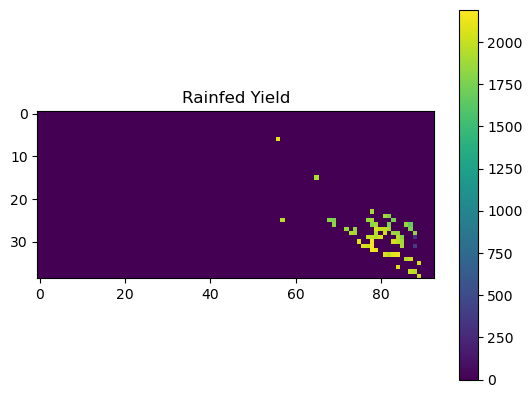

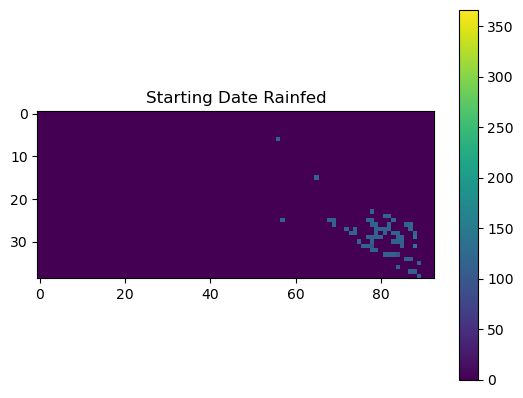

'Classified Yield'

In [65]:
'''visualize result'''

"""Yield Maps"""
plt.imshow(yield_map_rain, vmax = np.max([yield_map_rain]), vmin = 0)
plt.colorbar()
plt.title('Rainfed Yield')
plt.show()

# plt.imshow(yield_map_irr, vmax = np.max([yield_map_irr, yield_map_rain]), vmin = 0)
# plt.colorbar()
# plt.title('Irrigated Yield')
# plt.show()

"""Starting Date (Crop Calendar)"""
plt.imshow(starting_date_rain, vmin= 0, vmax = 366)
plt.colorbar()
plt.title('Starting Date Rainfed')
plt.show()

# plt.imshow(starting_date_irr, vmin= 0, vmax = 366)
# plt.colorbar()
# plt.title('Starting Date Irrigated')
# plt.show()

"""Classified Yield"""
# plt.imshow(yield_map_rain_class)
# plt.colorbar()
# plt.title('Classified Rainfed Yield')
# plt.show()
# plt.imshow(yield_map_irr_class)
# plt.colorbar()
# plt.show('Classified Irrigated Yield')
# plt.show()

In [66]:
# '''save result'''

obj_util.saveRaster(mask_path, r'.\data_output\module2\1979\barley\yield_map_rain.tif', yield_map_rain)

obj_util.saveRaster(mask_path, r'.\data_output\module2\1979\barley\starting_date_rain.tif', starting_date_rain)


# obj_utilities.saveRaster(mask_path, r'.\data_output\NB2\maiz_yld_rain_class.tif',yield_map_rain_class)
# obj_utilities.saveRaster(mask_path, r'.\data_output\NB2\maiz_yld_irr_class.tif',yield_map_irr_class)

### Thermal Screening Factor (fc1) Rainfed and Irrigated

In [67]:
screen_factor = aez.getThermalReductionFactor()
fc1_rain = screen_factor[0]

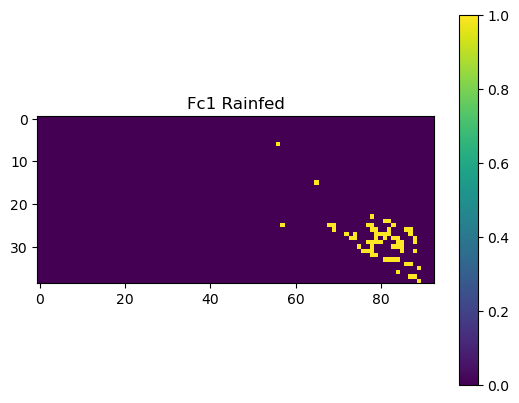

In [68]:
'''visualize additional outputs (Fc1)'''

plt.imshow(fc1_rain, vmax = 1, vmin = 0)
plt.colorbar()
plt.title('Fc1 Rainfed')
plt.show()


In [ ]:
# '''save fc1 result'''
obj_util.saveRaster(mask_path, r'.\data_output\module2\1979\barley\fc1_rain.tif', fc1_rain)

### Moisture Reduction Factor (fc2) (Only for Rainfed)

In [69]:
fc2 = aez.getMoistureReductionFactor()

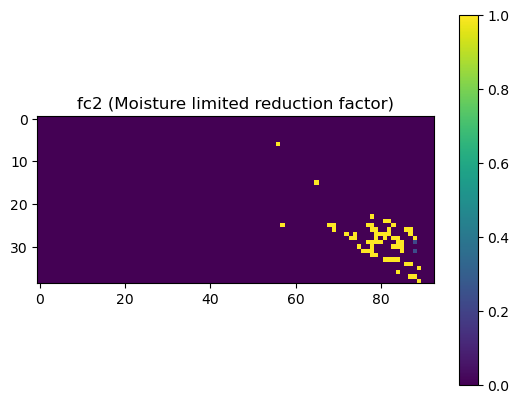

In [70]:
""" visualize additional outputs (Fc2) """

plt.imshow(fc2, vmin= 0, vmax = 1)
plt.colorbar()
plt.title('fc2 (Moisture limited reduction factor)')
plt.show()

In [ ]:
# saving fc2 result
obj_util.saveRaster(mask_path, r'.\data_output\NB2\maiz_fc2_rain.tif', fc2)